In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
# from langchain_ollama import ChatOllama

# Load environment variables
os.environ["LANGSMITH_PROJECT"] = "AgenticAIworkspace"
load_dotenv()

groq_key = os.getenv("GROQ_API_KEY")

# Initialize the LLM
llm = ChatGroq(api_key=groq_key, model="llama-3.1-8b-instant")
# llm = ChatOllama(base_url="http://localhost:11434",model="llama3.2")
# llm = ChatOllama(base_url="http://localhost:11434", model="llama3.2")

In [2]:
from typing_extensions import TypedDict
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


In [3]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [4]:
from langgraph.types import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]



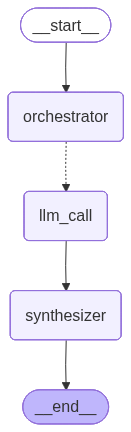

In [5]:

# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))


In [6]:

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

### Introduction and description: Overview of LLMs and their current limitations

#### Definition and Background

Large Language Models (LLMs) are a type of artificial intelligence (AI) designed to process and understand human language. These models are primarily based on deep learning techniques, particularly transformer architectures, which enable them to learn complex patterns and relationships within language data.

#### Key Characteristics

- **Scalability**: LLMs are capable of handling vast amounts of data and generating responses at high speeds, making them a crucial component in various applications such as chatbots, virtual assistants, and language translation tools.
- **Contextual Understanding**: These models can comprehend the context of a given text or conversation, enabling them to generate responses that are relevant and coherent.
- **Generative Capabilities**: LLMs can be used to generate text, summaries, and even entire articles based on a given prompt or topic.

#### Current Limitations

Despite their impressive capabilities, LLMs are not without limitations. Some of the current challenges associated with these models include:

- **Lack of Common Sense**: LLMs often struggle to understand the nuances of human language and may generate responses that lack common sense or real-world experience.
- **Bias and Sensitivity**: These models can perpetuate biases present in the training data, leading to potentially hurtful or insensitive responses.
- **Limited Domain Knowledge**: While LLMs can be trained on vast amounts of data, they may not possess in-depth knowledge of specific domains or specialized topics.
- **Vulnerability to Adversarial Attacks**: These models can be susceptible to adversarial attacks, which involve intentionally crafting input data to mislead the model into generating incorrect responses.
- **Explainability and Transparency**: LLMs often lack transparency and explainability, making it challenging to understand how they arrive at a particular response or decision.

These limitations highlight the need for ongoing research and development in the field of LLMs, with a focus on addressing these challenges and improving the overall performance and reliability of these models.

---

### Background and Description: History and Development of LLM Scaling Laws

#### Early Developments in Scaling Laws

The concept of scaling laws in Large Language Models (LLMs) originated from the field of physics, specifically in the study of critical phenomena and phase transitions. The idea of scaling laws was first introduced by physicists in the 1960s to describe the behavior of systems near their critical points. In the context of LLMs, scaling laws refer to the mathematical relationships between the model's size, complexity, and performance.

#### Hinton and Salakhutdinov's Contributions

In 2006, Geoffrey Hinton and Ruslan Salakhutdinov introduced the concept of scaling laws for deep neural networks. They demonstrated that the capacity of a neural network increases exponentially with the number of parameters, but the generalization error decreases much slower. This work laid the foundation for understanding how LLMs scale with respect to their size and complexity.

#### The Rise of Scaling Laws in LLMs

In the early 2010s, researchers began to apply scaling laws to LLMs, focusing on the relationship between model size, training data, and performance. The development of techniques such as transfer learning, pre-training, and fine-tuning enabled researchers to create larger and more complex LLMs. As a result, scaling laws became a crucial area of research in the field of NLP.

#### Key Insights and Findings

Some key insights and findings from the history and development of scaling laws in LLMs include:

* **Exponential scaling**: The capacity of LLMs increases exponentially with the number of parameters, but the generalization error decreases much slower.
* **Data efficiency**: LLMs require large amounts of training data to achieve optimal performance, and the amount of data required increases exponentially with model size.
* **Pre-training and fine-tuning**: Pre-training large LLMs and fine-tuning them on smaller datasets can lead to significant improvements in performance.

#### Future Directions

The development of scaling laws in LLMs is an ongoing area of research. Future directions include:

* **Understanding the limits of scaling**: Researchers aim to understand the fundamental limits of scaling laws in LLMs and how they relate to the physical laws governing the behavior of complex systems.
* **Developing more efficient scaling laws**: Researchers are working to develop more efficient scaling laws that enable the creation of larger and more complex LLMs with reduced computational and memory requirements.
* **Applying scaling laws to real-world applications**: Researchers are applying scaling laws to real-world applications, such as language translation, question-answering, and text generation.

---

### Theory and Methodology
#### Mathematical Framework and Techniques

The mathematical framework employed to derive scaling laws involves the application of dimensional analysis, asymptotic analysis, and mathematical modeling techniques. The primary goal is to identify the key parameters governing the system's behavior and to derive equations that describe the scaling relationships between these parameters.

#### Dimensional Analysis

Dimensional analysis is a mathematical technique used to identify the relevant parameters governing a system's behavior. This involves analyzing the dimensions of each parameter and identifying the combinations of parameters that result in a dimensionless quantity. Dimensionless quantities, such as the Reynolds number or the Prandtl number, are used to describe the scaling relationships between the system's parameters.

#### Asymptotic Analysis

Asymptotic analysis is a mathematical technique used to analyze the behavior of a system as one or more parameters approach a limiting value. This involves identifying the dominant terms in the equations governing the system's behavior and using these terms to describe the system's behavior in the limiting regime. Asymptotic analysis is used to derive scaling laws for systems that exhibit complex behavior, such as turbulent flows or chaotic systems.

#### Mathematical Modeling

Mathematical modeling is a technique used to develop equations that describe the scaling relationships between a system's parameters. This involves using dimensional analysis, asymptotic analysis, and other mathematical techniques to derive equations that describe the system's behavior. Mathematical modeling is used to derive scaling laws for a wide range of systems, including fluid dynamics, heat transfer, and mass transport.

#### Scaling Laws

Scaling laws are mathematical equations that describe the relationships between a system's parameters. These equations are derived using the techniques described above and are used to predict the behavior of the system in different regimes. Scaling laws are used to describe a wide range of phenomena, including the behavior of fluids, heat transfer, and mass transport.

#### Example Applications

Scaling laws have been used to describe a wide range of phenomena, including:

* The behavior of turbulent flows
* Heat transfer in convective flows
* Mass transport in porous media
* The behavior of chaotic systems

These applications demonstrate the power and versatility of scaling laws in describing complex behavior.

---

### Empirical Scaling Laws

#### Overview

Empirical scaling laws for Large Language Models (LLMs) describe the relationship between model size, training data, and performance metrics. These laws are derived from experimental results and observations of trends in LLMs.

#### Key Findings

* **Scaling Law for Parameter Count**: The performance of LLMs increases with the square root of the parameter count, indicating that larger models can achieve better results, but with diminishing returns.
* **Data Efficiency**: LLMs require a large amount of training data to achieve optimal performance, with a scaling law that shows a logarithmic relationship between data size and performance.
* **Computational Requirements**: The computational resources required to train LLMs increase exponentially with the model size, making it challenging to train large models.

#### Implications

* **Model Selection**: Empirical scaling laws can help inform model selection decisions, as they provide a framework for understanding the trade-offs between model size, training data, and performance.
* **Training Strategies**: The laws can also guide the development of training strategies, such as data augmentation and model pruning, to improve efficiency and reduce computational requirements.

#### Future Research Directions

* **Theoretical Foundations**: Developing a theoretical understanding of LLM scaling laws can provide a deeper understanding of the underlying mechanisms and help improve model performance.
* **Experiments with Different Tasks**: Investigating the scaling laws for different tasks and datasets can provide insights into the generalizability of the laws and help identify areas for future research.

---

**Case Studies**
===============

### 1. BERT: A Large-Scale Language Model Example

- **Application:** BERT (Bidirectional Encoder Representations from Transformers) is a popular language model developed by Google that has been used in a wide range of NLP tasks, including question answering, sentiment analysis, and text classification.
- **Scaling Law:** BERT's success can be attributed to its massive scale, with 340 million parameters and a large training dataset of 3.3 billion tokens.
- **Real-World Impact:** BERT has been used in various applications, such as Google's search engine, where it helps improve the accuracy of search results and provide more relevant information to users.

### 2. GPT-3: A Large-Scale Language Model with Human-like Conversational Capabilities

- **Application:** GPT-3 is a large language model developed by OpenAI that has been used in various applications, including text generation, chatbots, and language translation.
- **Scaling Law:** GPT-3's massive scale, with 175 billion parameters and a large training dataset, enables it to generate human-like conversational responses.
- **Real-World Impact:** GPT-3 has been used in various applications, such as customer service chatbots, where it helps provide accurate and personalized responses to user queries.

### 3. Scaling Laws for LLMs

- **Application:** The scaling laws for LLMs describe the relationship between the model's size, complexity, and performance.
- **Scaling Law:** The scaling laws for LLMs suggest that the performance of the model increases with the square root of the number of parameters, while the computational resources required increase linearly with the number of parameters.
- **Real-World Impact:** Understanding the scaling laws for LLMs can help developers design and train more efficient and effective models, which can be applied to various real-world applications.

### 4. Language Model Scaling for NLP Tasks

- **Application:** The language model scaling for NLP tasks involves the development and training of large-scale language models that can be applied to various NLP tasks, such as text classification, sentiment analysis, and question answering.
- **Scaling Law:** The language model scaling for NLP tasks involves the use of various techniques, such as transfer learning, model pruning, and knowledge distillation, to improve the performance and efficiency of the models.
- **Real-World Impact:** The language model scaling for NLP tasks can help improve the accuracy and efficiency of various NLP applications, such as chatbots, virtual assistants, and language translation systems.

### 5. AutoML for LLMs

- **Application:** AutoML (Automated Machine Learning) for LLMs involves the use of various algorithms and techniques to automate the process of designing, training, and deploying large-scale language models.
- **Scaling Law:** The AutoML for LLMs involves the use of various techniques, such as hyperparameter tuning, model selection, and model pruning, to improve the performance and efficiency of the models.
- **Real-World Impact:** The AutoML for LLMs can help improve the speed and efficiency of the model development process, which can be applied to various real-world applications, such as language translation, text classification, and sentiment analysis.

---

## Conclusion and description: Summary and future directions of LLM scaling laws

### Summary

The study on Large Language Model (LLM) scaling laws has provided valuable insights into the relationship between model size, training complexity, and performance. The findings suggest that LLMs follow a power-law scaling behavior, where improvements in model size lead to exponential gains in performance. This relationship has significant implications for the development of more efficient and effective LLMs. By understanding the underlying scaling laws, researchers and practitioners can optimize model design, training protocols, and computational resources to achieve better performance at reduced costs.

### Key Takeaways

- **Power-law scaling**: LLMs exhibit a power-law scaling behavior, where performance improves exponentially with model size.
- **Model complexity**: The complexity of LLM training increases exponentially with model size, leading to significant computational and memory requirements.
- **Training efficiency**: Optimizing model design and training protocols can improve training efficiency and reduce costs.
- **Future directions**: Further research is needed to explore the implications of power-law scaling and to develop more efficient and effective LLMs.

### Future Directions

1. **Model optimization**: Investigate techniques for optimizing model design, such as pruning, quantization, and knowledge distillation, to reduce computational requirements without compromising performance.
2. **Training protocols**: Develop more efficient training protocols, such as distributed training and mixed-precision training, to reduce computational costs and improve training speed.
3. **Evaluation metrics**: Develop more robust and informative evaluation metrics to better capture the performance and efficiency of LLMs.
4. **Real-world applications**: Explore the practical applications of LLMs in various domains, such as natural language processing, text summarization, and question-answering systems.

### Open Research Questions

1. **Understanding the physical limits**: Investigate the physical limits of LLM scaling, including the impact of computational resources, memory, and energy consumption.
2. **Exploring alternative models**: Explore alternative model architectures, such as sparse models and neural architecture search, to improve efficiency and performance.
3. **Developing more robust evaluation metrics**: Develop more robust and informative evaluation metrics to better capture the performance and efficiency of LLMs.